## Notebook #1b in the simulation series

Here we aim to validate the beam map. We also aim to break the degeneracy between the trasnmitter flux (in unknwon units!) and the receiver gain.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
import astropy.units as u
import healpy as hp
from pygdsm import GlobalSkyModel16

%matplotlib widget

In [2]:
d = np.load("data_models.npz")

data = np.ma.array(d["data"], mask=d["mask"])
times = d["times"]
freqs = d["freqs"]  # MHz
beam_alm = d["beam_alm"]  # beam alm model
beam_hp = d["beam_hp"]  # healpix map of the alm model
g_rx = d["g_rx"]  # receiver gain (mean of beam factored out)

BEAM_NSIDE = hp.get_nside(beam_hp[0])
print(BEAM_NSIDE)
BEAM_NPIX = hp.nside2npix(BEAM_NSIDE)

tx_flux = np.load("../sim_v003.npz")["tx_flux"][0]


# think tx flux is not in right units so we scale by SCALE

# try1: tx_flux was given in K/sr so we should multiply by sr
# this seemed to be in the wrong direction, gain became so low sky didn't matter!
# SCALE = BEAM_NPIX / (4 * np.pi)  # beam dA

# try 2: tx flux was in K, we need to scale by our NPIX / ARP's NPIX
#arp_nside_guess = 64
#SCALE = (BEAM_NSIDE / arp_nside_guess) ** 2

# try 3: we need a higher gain  --> this is pretty good!! trying to find something more physical
#SCALE = 1/(1.6 * BEAM_NPIX)

# try 4: like try 2 but guess his nside is 1024 like pygdsm hi res
arp_nside_guess = 1024
SCALE = (BEAM_NSIDE / arp_nside_guess) ** 2

print(SCALE)

tx_flux *= SCALE
g_rx /= SCALE

16
0.000244140625


In [3]:
overwrite_sky = False
sky_path = Path("sky_topo.npy")
if overwrite_sky or not sky_path.exists():
    new_sky = True
else:
    new_sky = False
    sky_topo = np.load(sky_path)

In [4]:
# pixel centers for topocentric hp grid
theta_topo, phi_topo = hp.pix2ang(BEAM_NSIDE, np.arange(BEAM_NPIX))
  
alt_topo = np.pi/2 - theta_topo
alt_topo = alt_topo * u.rad
az_topo  = phi_topo * u.rad

if new_sky:
    gsm = GlobalSkyModel16(freq_unit="MHz", data_unit="TRJ", resolution="lo", include_cmb=True)
    gsm_map = gsm.generate(freqs)
    hp.mollview(gsm_map[0])
    
    gsm_nside = hp.get_nside(gsm_map[0])
    gsm_npix = len(gsm_map[0])
    gal_lon, gal_lat = hp.pix2ang(gsm_nside, np.arange(gsm_npix), lonlat=True)
    
    LAT = 39.247699
    LON = -113.402660
    HGT = 1800 # m
    
    loc = EarthLocation(LON, LAT, HGT)
    obstimes = Time(times, format="jd")
    altaz = [AltAz(location=loc, obstime=t) for t in obstimes]

    
    # transform to altaz
    sky_topo = np.empty((len(times), len(freqs), BEAM_NPIX), dtype=np.float32)
    for i, topo_frame in enumerate(altaz):
        sc_altaz = SkyCoord(alt=alt_topo, az=az_topo, frame=topo_frame)
        sc_gal = sc_altaz.transform_to("galactic")
        
        # nearest-neighbor interpolation
        pix = hp.ang2pix(gsm_nside, sc_gal.l.value, sc_gal.b.value, lonlat=True)
        sky_topo[i, :, :] = gsm_map[:, pix]

    np.save(sky_path, sky_topo)

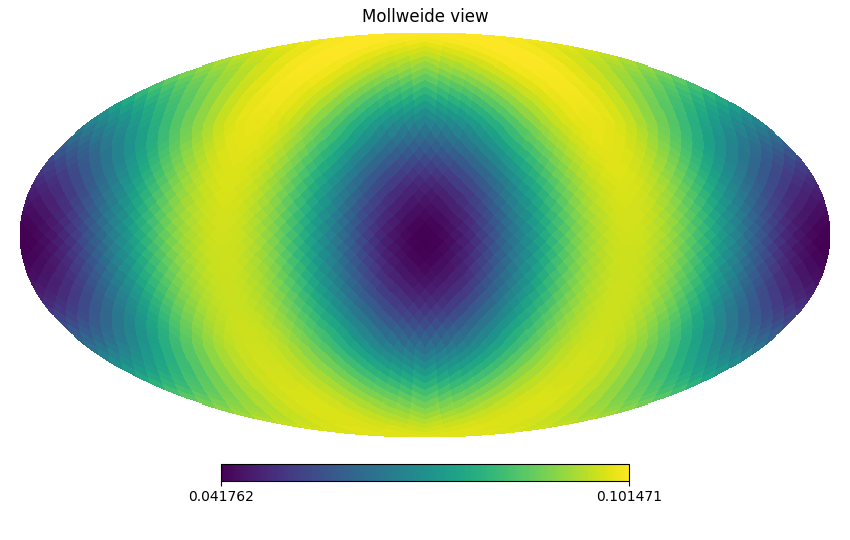

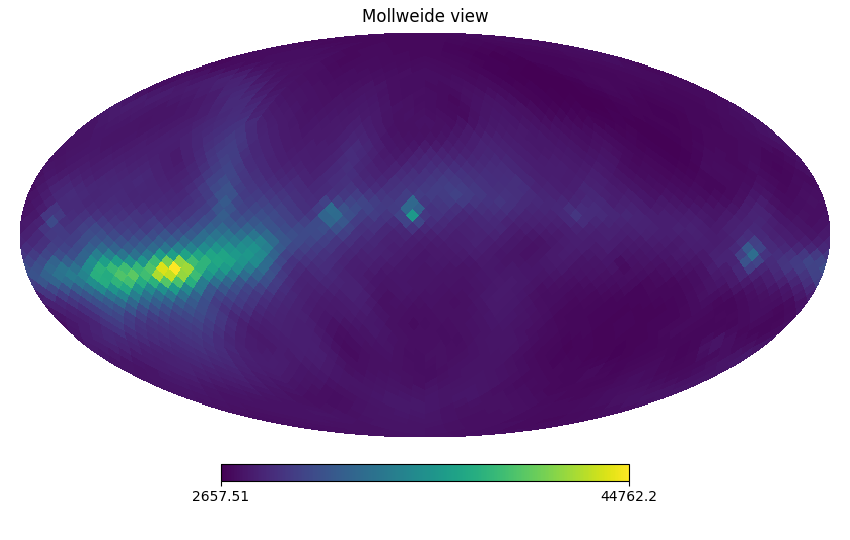

In [5]:
hp.mollview(beam_hp[0])
plt.show()

hp.mollview(sky_topo[0, 0])
plt.show()

## Multiply sky with beam

In [6]:
# basic (and wrong) horizon profile
horizon = np.ones(BEAM_NPIX, dtype=int)  # 1s above horizon
horizon[alt_topo.value < 0] = 0  # 0s below horizon

# assign some ground temp and receiver temp
t_gnd = 300
t_rx = 75

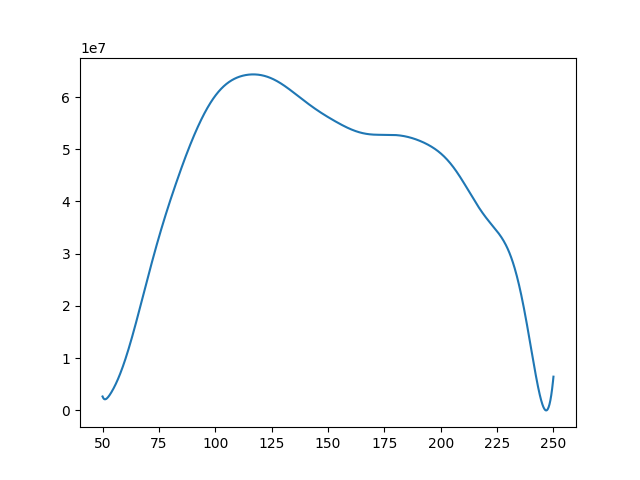

In [7]:
plt.figure()
plt.plot(freqs, sky_topo[0].mean(axis=-1) * g_rx)
plt.show()

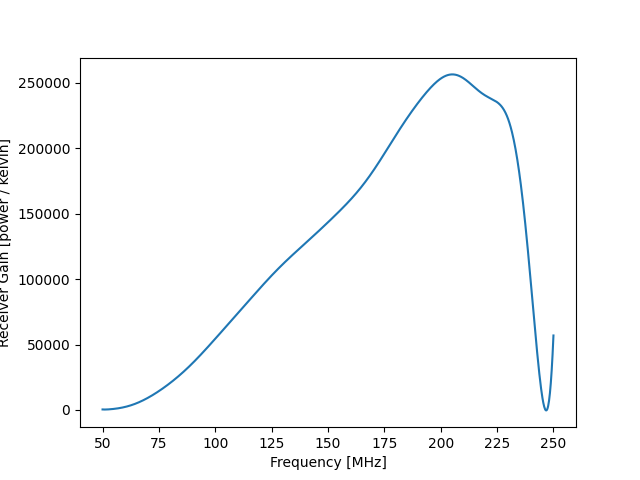

In [8]:
plt.figure()
plt.plot(freqs, g_rx)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Receiver Gain [power / kelvin]")
plt.show()

In [9]:
def sim(sky, beam, horizon, g_rx, t_gnd, t_rx, tx_flux=None):
    """
    Simulation for a single orienation of the box, assuming everything has been rotated to the world frame.
    Beam is assumed to be normalized so it integrates to 1.
    If tx_flux is given, add a transmitter directly below the antenna

    shapes:
    sky = (ntimes, nfreq, npix)
    beam = (nfreq, npix)
    horizon = (npix)
    g_rx = (nfreq)
    t_gnd = scalar
    t_rx = scalar
    tx_flux = (nfreq)
    """
    gnd_pix = (horizon == 0)
    print(np.sum(gnd_pix) / len(gnd_pix))
    sim_sky = sky.copy()
    sim_sky[:, :, gnd_pix] = t_gnd
    dA = 4*np.pi / len(horizon)
    if tx_flux is not None:
        sim_sky[:, :, -1] += tx_flux[None, :] / dA
    t_ant = g_rx[None, :] * np.sum(sim_sky * beam[None, :, :] * dA, axis=-1) + t_rx
    if tx_flux is None:
        return t_ant
    # mask the same way as the data if tx is on
    tx_mask = np.zeros(t_ant.shape, dtype=bool)
    tx_mask[:, ::16] = True
    return np.ma.array(t_ant, mask=tx_mask)

In [10]:
#t_ant = sim(sky_topo[0], beam_hp, horizon, G_rx, 3000, 100)
t_ant = sim(sky_topo, beam_hp, horizon, g_rx, t_gnd, t_rx, tx_flux=tx_flux)
#t_ant0 = sim(np.zeros_like(sky_topo), beam_hp, np.ones_like(horizon), g_rx, 0, 0, tx_flux=tx_flux)[0]

0.4895833333333333


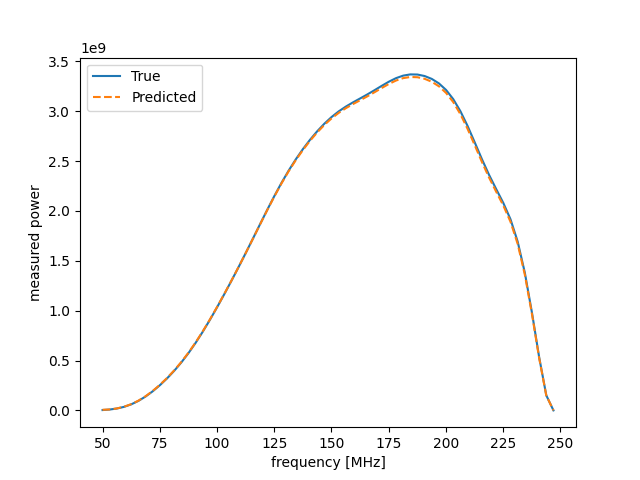

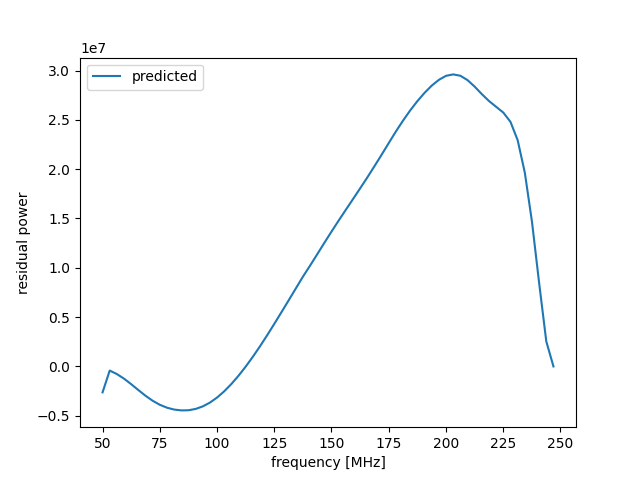

In [11]:
plt.figure()
plt.plot(freqs[::16], data.data[0, 0, ::16], label="True")
plt.plot(freqs[::16], t_ant.data[0, ::16], label="Predicted", ls="--")
#plt.plot(freqs[::16], t_ant0.data[::16], label="Predicted no sky", ls="-.")
plt.legend()
plt.xlabel("frequency [MHz]")
plt.ylabel("measured power")
plt.show()

plt.figure()
plt.plot(freqs[::16], data.data[0, 0, ::16] - t_ant.data[0, ::16], label="predicted")
#plt.plot(freqs[::16], data.data[0, 0, ::16] - t_ant0.data[::16], label="predicted no sky", ls="--")
plt.legend()
plt.xlabel("frequency [MHz]")
plt.ylabel("residual power")
plt.show()

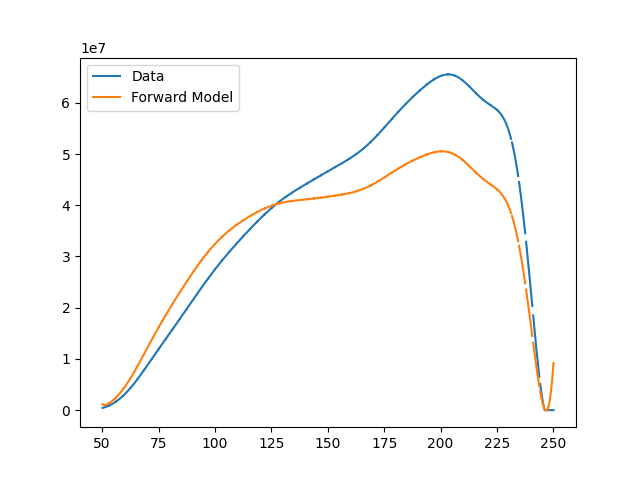

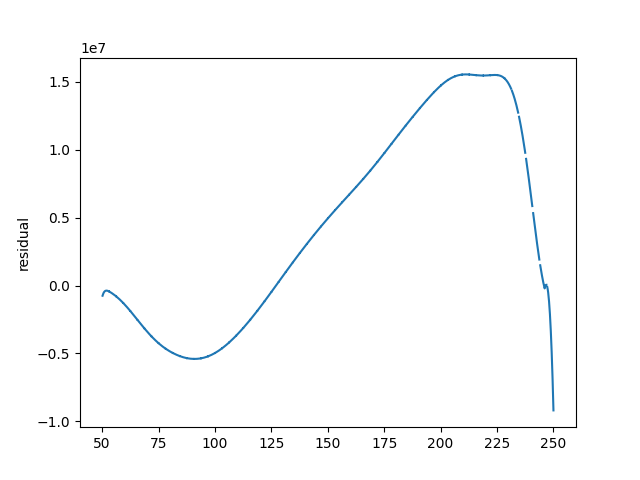

In [12]:
plt.figure()
plt.plot(freqs, data[0, 0], label="Data")
plt.plot(freqs, t_ant[0], label="Forward Model")
plt.legend()
#plt.yscale("log")
plt.show()


plt.figure()
plt.plot(freqs, data[0,0] - t_ant[0])
plt.ylabel("residual")
plt.show()

In [13]:
import matplotlib.colors as colors

In [14]:
def waterfall(data, times=times, freqs=freqs, log=False, vmin=None, vmax=None, cmap="plasma", scale=1, title=None, fname=None):
    if vmin is not None:
        vmin /= scale
    if vmax is not None:
        vmax /= scale
    if log:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    plt.figure()
    X, Y = np.meshgrid(freqs, times-times[0])
    cmap = plt.get_cmap(cmap)
    cmap.set_over("0.75")
    plt.pcolormesh(X, Y, data / scale, rasterized=True, shading="nearest",cmap=cmap, norm=norm)
    #plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.colorbar(label="Uncalibrated Amplitude [arb. linear units]", extend="both")
    #plt.ylabel("Local Time")
    plt.xlabel("Frequency [MHz]")
    if title:
        plt.title(title)
    if fname is not None:
        plt.savefig(fname)
    plt.show()

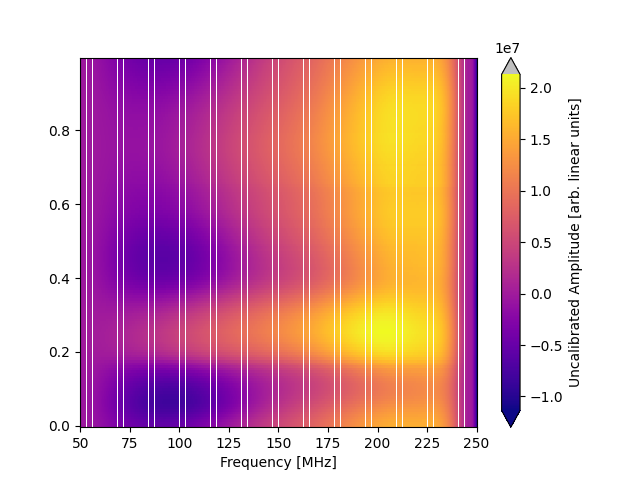

In [15]:
waterfall(data[:, 0] - t_ant)

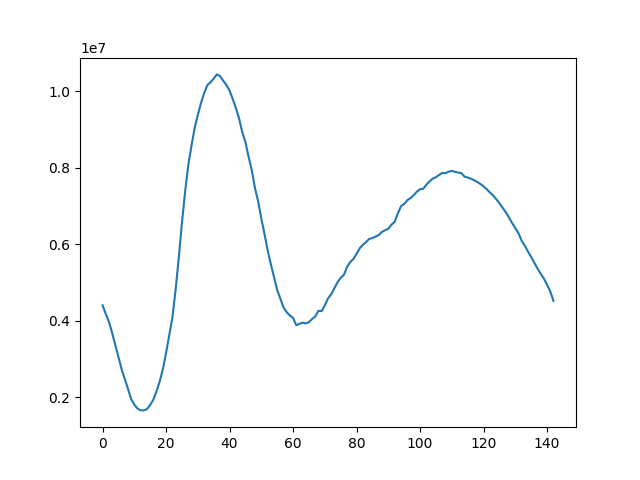

In [16]:
plt.figure()
plt.plot(np.mean(data[:, 0], axis=-1) - np.mean(t_ant, axis=-1))
plt.show()

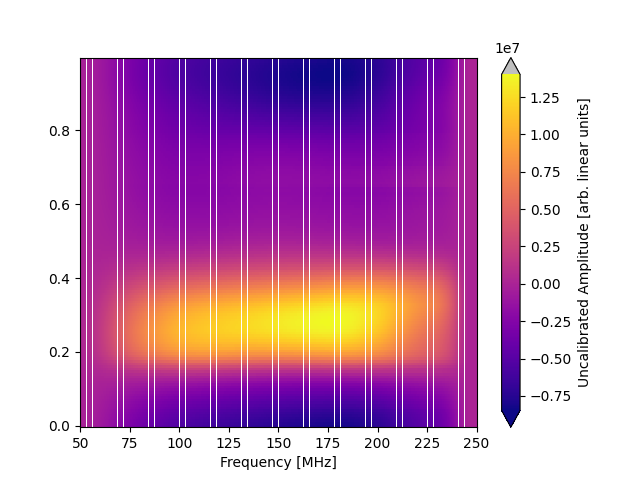

In [17]:
dmean = np.mean(data[:, 0], axis=0)
dfl = data[:, 0] -dmean
waterfall(dfl, scale=1)

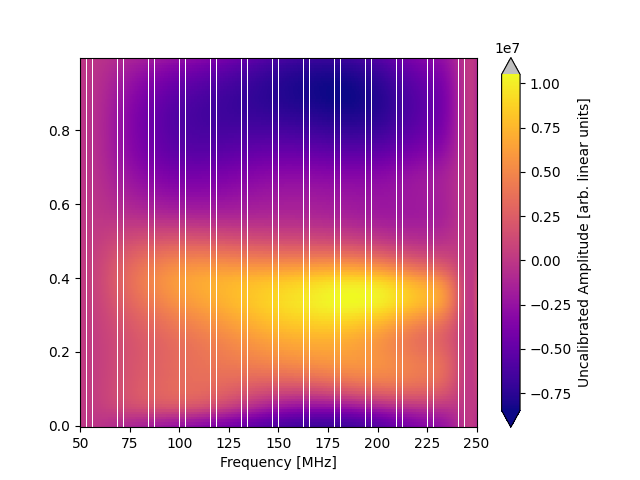

In [18]:
ta_mean = np.mean(t_ant, axis=0)
tafl = t_ant-ta_mean
waterfall(tafl, scale=1)

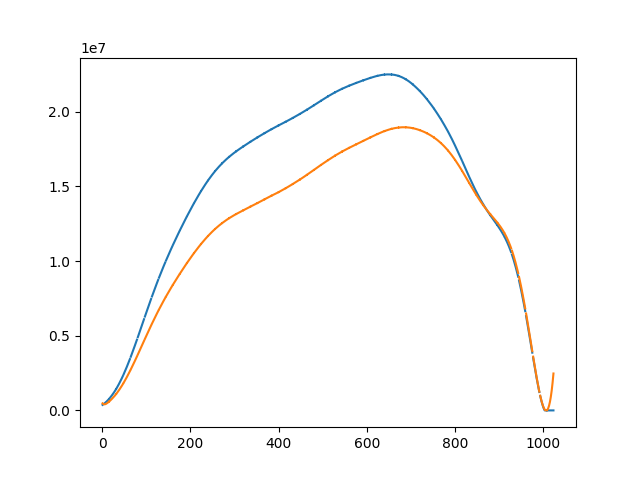

In [19]:
plt.figure()
plt.plot(np.max(dfl, axis=0) - np.min(dfl, axis=0))
plt.plot((np.max(tafl, axis=0) - np.min(tafl, axis=0)))
plt.show()

## Save updated models

In [20]:
overwrite = False
fname = "data_models.npz"
if overwrite or not Path(fname).exists():
    np.savez(fname, data=data.data, mask=data.mask, times=times, freqs=freqs, beam_alm=beam_alm, beam_hp=beam_hp, g_rx=g_rx, tx_flux=tx_flux)